In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize

# List of NIFTY 50 components
nifty50_tickers = [
    'RELIANCE.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS',
    'KOTAKBANK.NS', 'HINDUNILVR.NS', 'AXISBANK.NS', 'SBIN.NS', 'BAJFINANCE.NS',
    'ITC.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'HCLTECH.NS', 'HDFCLIFE.NS',
    'MARUTI.NS', 'SUNPHARMA.NS', 'LT.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'
]

# Fetch historical data for NIFTY 50 index
nifty50_index = '^NSEI'
nifty50_data = yf.download(nifty50_index, start='2004-07-21', end='2024-07-21')
nifty50_close = nifty50_data[['Close']]
nifty50_close['Market Return'] = nifty50_close['Close'].pct_change()

# Fetch historical data for each stock
stock_data = {}
for ticker in nifty50_tickers:
    stock_data[ticker] = yf.download(ticker, start='2004-07-21', end='2024-07-21')[['Close']]
    stock_data[ticker]['Daily Return'] = stock_data[ticker]['Close'].pct_change()


[*********************100%%**********************]  1 of 1 completed
<ipython-input-40-6c2a41ff341f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nifty50_close['Market Return'] = nifty50_close['Close'].pct_change()
[*********************100%%**********************]  1 of 1 completed
<ipython-input-40-6c2a41ff341f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data[ticker]['Daily Return'] = stock_data[ticker]['Close'].pct_change()
[*********************100%%**********************]  1 of 1 comp

In [19]:
# Define the risk-free rate
risk_free_rate = 0.06 / 252  # Daily risk-free rate

# Calculate excess returns for the market
nifty50_close['Excess Return_market'] = nifty50_close['Market Return'] - risk_free_rate

# Calculate excess returns for each stock
for ticker in nifty50_tickers:
    stock_data[ticker]['Excess Return_stock'] = stock_data[ticker]['Daily Return'] - risk_free_rate


<ipython-input-19-ff96b2023c00>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nifty50_close['Excess Return_market'] = nifty50_close['Market Return'] - risk_free_rate
<ipython-input-19-ff96b2023c00>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data[ticker]['Excess Return_stock'] = stock_data[ticker]['Daily Return'] - risk_free_rate


In [21]:
# Calculate average daily returns and covariance matrix
returns = pd.DataFrame({ticker: stock_data[ticker]['Daily Return'] for ticker in nifty50_tickers})
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define portfolio weights
num_assets = len(nifty50_tickers)
weights = np.random.random(num_assets)
weights /= np.sum(weights)

# Calculate portfolio return and volatility
portfolio_return = np.dot(weights, mean_returns)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

print(f"Expected Portfolio Return: {portfolio_return * 252:.2%}")
print(f"Expected Portfolio Volatility: {portfolio_volatility * np.sqrt(252):.2%}")


Expected Portfolio Return: 26.46%
Expected Portfolio Volatility: 24.75%


In [22]:
# Objective function to minimize (negative Sharpe Ratio)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - (portfolio_return - risk_free_rate) / portfolio_volatility

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess for the weights
initial_guess = num_assets * [1. / num_assets]

# Optimization
result = minimize(neg_sharpe_ratio, initial_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = result.x

# Optimal portfolio return and volatility
optimal_portfolio_return = np.dot(optimal_weights, mean_returns)
optimal_portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

print(f"Optimal Portfolio Return: {optimal_portfolio_return * 252:.2%}")
print(f"Optimal Portfolio Volatility: {optimal_portfolio_volatility * np.sqrt(252):.2%}")
print(f"Optimal Weights: {optimal_weights}")


Optimal Portfolio Return: 27.02%
Optimal Portfolio Volatility: 19.27%
Optimal Weights: [3.11129153e-19 4.02496582e-02 0.00000000e+00 2.31574753e-02
 4.76549921e-18 1.08622694e-01 6.86085878e-02 1.72546004e-02
 0.00000000e+00 2.32130803e-02 3.11685927e-02 5.75283552e-03
 3.48760359e-01 1.01648304e-01 0.00000000e+00 7.95126044e-03
 1.95423537e-01 2.81890160e-02 0.00000000e+00 0.00000000e+00]


In [23]:
# Convert annual risk-free rate to daily risk-free rate
annual_risk_free_rate = 0.07
daily_risk_free_rate = annual_risk_free_rate / 252


In [24]:
from scipy.optimize import minimize

# Objective function to minimize (negative Sharpe Ratio)
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - (portfolio_return - risk_free_rate) / portfolio_volatility

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess for the weights
initial_guess = num_assets * [1. / num_assets]

# Optimization with updated risk-free rate
result = minimize(neg_sharpe_ratio, initial_guess, args=(mean_returns, cov_matrix, daily_risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = result.x

# Optimal portfolio return and volatility
optimal_portfolio_return = np.dot(optimal_weights, mean_returns)
optimal_portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

print(f"Optimal Portfolio Return: {optimal_portfolio_return * 252:.2%}")
print(f"Optimal Portfolio Volatility: {optimal_portfolio_volatility * np.sqrt(252):.2%}")
print(f"Optimal Weights: {optimal_weights}")


Optimal Portfolio Return: 27.34%
Optimal Portfolio Volatility: 19.57%
Optimal Weights: [0.00000000e+00 3.58776318e-02 0.00000000e+00 1.56024029e-02
 0.00000000e+00 1.16624564e-01 6.26052208e-02 2.08204895e-02
 0.00000000e+00 2.47366179e-02 2.30976243e-02 3.08070968e-03
 3.58273041e-01 1.06896236e-01 5.46614141e-18 4.37431249e-03
 1.97931779e-01 3.00793698e-02 2.28217212e-18 2.10484805e-18]


In [29]:
# Total investment amount
total_investment = 50000

# Calculate investment amounts for each stock
investment_amounts = optimal_weights * total_investment

# Display investment amounts
investment_df = pd.DataFrame({
    'Stock': nifty50_tickers,
    'Optimal Weight': optimal_weights,
    'Investment Amount (₹)': investment_amounts
})
# Create DataFrame
df = pd.DataFrame(data)

# Format the 'Optimal Weight' to 4 decimal places
df['Optimal Weight'] = df['Optimal Weight'].apply(lambda x: f"{x:.4f}")

# Format the 'Investment Amount (₹)' to 2 decimal places
df['Investment Amount (₹)'] = df['Investment Amount (₹)'].apply(lambda x: f"{x:,.2f}")

print(df)



            Stock Optimal Weight Investment Amount (₹)
0     RELIANCE.NS         0.0000                  0.00
1     HDFCBANK.NS         0.0359              1,793.88
2    ICICIBANK.NS         0.0000                  0.00
3         INFY.NS         0.0156                780.12
4          TCS.NS         0.0000                  0.00
5    KOTAKBANK.NS         0.1166              5,831.23
6   HINDUNILVR.NS         0.0626              3,130.26
7     AXISBANK.NS         0.0208              1,041.02
8         SBIN.NS         0.0000                  0.00
9   BAJFINANCE.NS         0.0247              1,236.83
10         ITC.NS         0.0231              1,154.88
11  BHARTIARTL.NS         0.0031                154.04
12  ASIANPAINT.NS         0.3583             17,913.65
13     HCLTECH.NS         0.1069              5,344.81
14    HDFCLIFE.NS         0.0000                  0.00
15      MARUTI.NS         0.0044                218.72
16   SUNPHARMA.NS         0.1979              9,896.59
17        

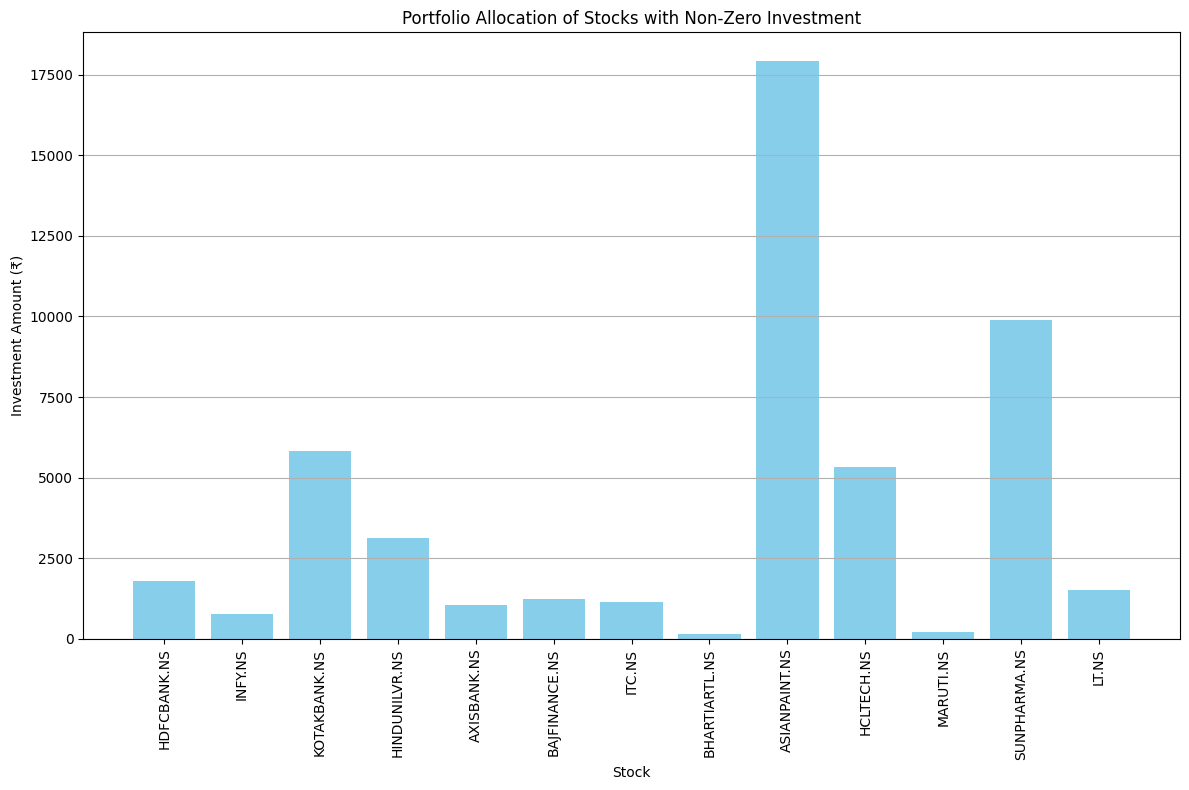

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame with scientific notation
data = {
    'Stock': [
        'RELIANCE.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS',
        'KOTAKBANK.NS', 'HINDUNILVR.NS', 'AXISBANK.NS', 'SBIN.NS', 'BAJFINANCE.NS',
        'ITC.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'HCLTECH.NS', 'HDFCLIFE.NS',
        'MARUTI.NS', 'SUNPHARMA.NS', 'LT.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'
    ],
    'Optimal Weight': [
        0.000000e+00, 3.587763e-02, 0.000000e+00, 1.560240e-02, 0.000000e+00,
        1.166246e-01, 6.260522e-02, 2.082049e-02, 0.000000e+00, 2.473662e-02,
        2.309762e-02, 3.080710e-03, 3.582730e-01, 1.068962e-01, 5.466141e-18,
        4.374312e-03, 1.979318e-01, 3.007937e-02, 2.282172e-18, 2.104848e-18
    ],
    'Investment Amount (₹)': [
        '0.00', '1,793.88', '0.00', '780.12', '0.00',
        '5,831.23', '3,130.26', '1,041.02', '0.00', '1,236.83',
        '1,154.88', '154.04', '17,913.65', '5,344.81', '0.00',
        '218.72', '9,896.59', '1,503.97', '0.00', '0.00'
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Remove commas and convert to float
df['Investment Amount (₹)'] = df['Investment Amount (₹)'].str.replace(',', '').astype(float)

# Filter out stocks with zero allocation
non_zero_df = df[df['Investment Amount (₹)'] > 0]

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(non_zero_df['Stock'], non_zero_df['Investment Amount (₹)'], color='skyblue')
plt.xlabel('Stock')
plt.ylabel('Investment Amount (₹)')
plt.title('Portfolio Allocation of Stocks with Non-Zero Investment')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Sample data (this should be replaced with actual historical data)
data = {
    'Stock': [
        'RELIANCE.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS',
        'KOTAKBANK.NS', 'HINDUNILVR.NS', 'AXISBANK.NS', 'SBIN.NS', 'BAJFINANCE.NS',
        'ITC.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'HCLTECH.NS', 'HDFCLIFE.NS',
        'MARUTI.NS', 'SUNPHARMA.NS', 'LT.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'
    ],
    'Investment Amount (₹)': [
        0.000000e+00, 1.793882e+03, 0.000000e+00, 7.801201e+02, 0.000000e+00,
        5.831228e+03, 3.130261e+03, 1.041024e+03, 0.000000e+00, 1.236831e+03,
        1.154881e+03, 1.540355e+02, 1.791365e+04, 5.344812e+03, 2.733071e-13,
        2.187156e+02, 9.896589e+03, 1.503968e+03, 1.141086e-13, 1.052424e-13
    ]
}
df = pd.DataFrame(data)

# Assuming 'historical_data' DataFrame with historical stock prices and returns
# Generating sample features and target variable
historical_data = pd.DataFrame({
    'Feature1': np.random.rand(100),  # Replace with actual features
    'Feature2': np.random.rand(100),  # Replace with actual features
    'Return': np.random.rand(100)  # Replace with actual returns
})

# Prepare data
X = historical_data[['Feature1', 'Feature2']]
y = historical_data['Return']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict returns
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')


Mean Squared Error: 0.09


In [36]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Sample returns data (replace with actual historical returns)
returns = pd.DataFrame({
    'RELIANCE.NS': np.random.rand(100),
    'HDFCBANK.NS': np.random.rand(100),
    'ICICIBANK.NS': np.random.rand(100),
    # Add other stocks
})

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Define the objective function (minimize volatility)
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_volatility, portfolio_return

def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

# Constraints and bounds
num_assets = len(mean_returns)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess
initial_weights = num_assets * [1. / num_assets,]

# Optimization
optimal = minimize(minimize_volatility, initial_weights, args=(mean_returns, cov_matrix),
                   method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimal.x
print("Optimal Weights: ", optimal_weights)


Optimal Weights:  [0.34669446 0.36270964 0.2905959 ]


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Generate sample risk labels (0 = low risk, 1 = high risk)
# Replace with actual risk labels
historical_data['Risk'] = np.where(historical_data['Return'] > historical_data['Return'].median(), 1, 0)

# Prepare data
X = historical_data[['Feature1', 'Feature2']]
y = historical_data['Risk']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict risk
y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.45


In [39]:
from sklearn.cluster import KMeans

# Sample data (replace with actual features)
risk_features = pd.DataFrame({
    'Volatility': np.random.rand(20),
    'Returns': np.random.rand(20)
})

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(risk_features)
clusters = kmeans.labels_

# Add cluster labels to DataFrame
risk_features['Cluster'] = clusters
print(risk_features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


    Volatility   Returns  Cluster
0     0.878382  0.596259        0
1     0.474624  0.735837        0
2     0.315491  0.342383        1
3     0.715440  0.220260        1
4     0.253381  0.245703        1
5     0.013409  0.834495        2
6     0.139479  0.851557        2
7     0.573620  0.346060        1
8     0.723079  0.220325        1
9     0.508102  0.874884        0
10    0.317850  0.575325        2
11    0.708251  0.014739        1
12    0.789569  0.952088        0
13    0.824905  0.638896        0
14    0.063753  0.761314        2
15    0.231845  0.536262        2
16    0.017495  0.986680        2
17    0.691583  0.598248        0
18    0.952661  0.195971        1
19    0.150325  0.947974        2


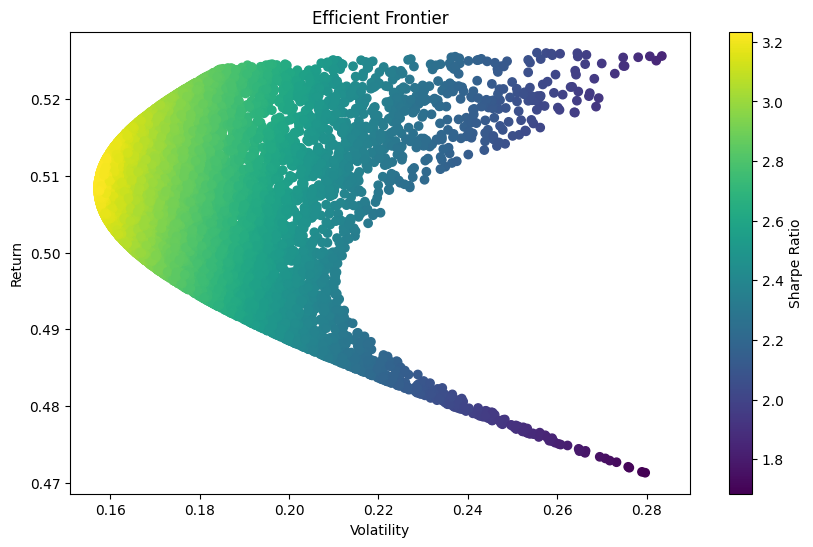

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define number of portfolios to simulate
num_portfolios = 10000

# Initialize lists to hold portfolio metrics
results = np.zeros((num_portfolios, 3))
weights_record = []

# Function to calculate portfolio return and volatility
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# Generate random portfolios
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)

    # Calculate portfolio performance
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)

    # Calculate Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Store results
    results[i, 0] = portfolio_return
    results[i, 1] = portfolio_volatility
    results[i, 2] = sharpe_ratio
    weights_record.append(weights)

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Return', 'Volatility', 'Sharpe Ratio'])

# Plot efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe Ratio'], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


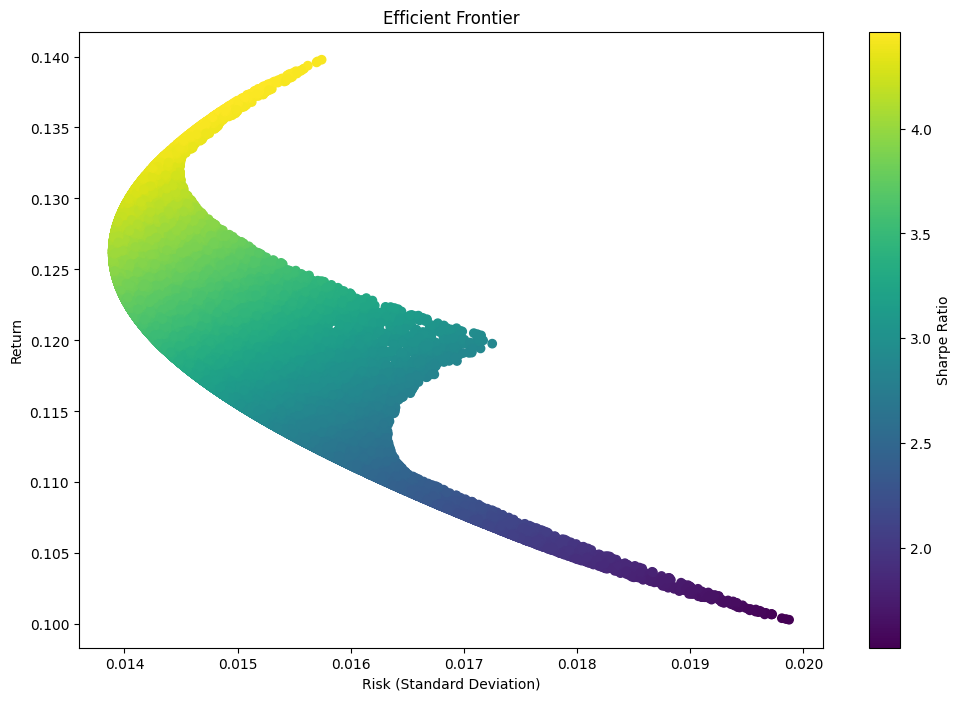

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Number of portfolios
num_portfolios = 50000

# Generate random portfolio weights
def generate_portfolios(returns, cov_matrix, num_portfolios):
    num_assets = len(returns)
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_return = np.dot(weights, returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_stddev
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = portfolio_sharpe
    return results

# Assume returns and covariance matrix are given
returns = np.array([0.1, 0.12, 0.14])  # Example returns for three assets
cov_matrix = np.array([[0.0004, 0.0002, 0.0001],
                       [0.0002, 0.0003, 0.00015],
                       [0.0001, 0.00015, 0.00025]])  # Example covariance matrix

# Risk-free rate
risk_free_rate = 0.07

# Generate portfolios
results = generate_portfolios(returns, cov_matrix, num_portfolios)

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe'])

# Plot efficient frontier
plt.figure(figsize=(12, 8))
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.show()


Optimal Portfolio with Highest Sharpe Ratio:
Return: 13.75%
Risk: 1.51%
Sharpe Ratio: 4.46
Weights in Each Asset:
Asset 1: 0.01%
Asset 2: 12.42%
Asset 3: 87.56%


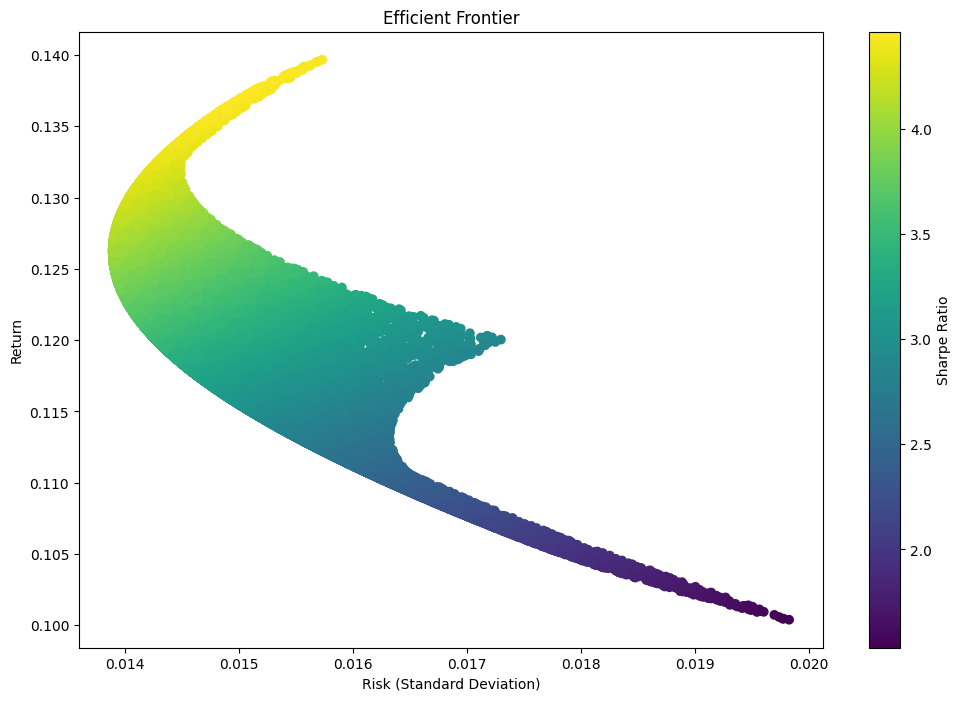

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of portfolios
num_portfolios = 50000

# Generate random portfolio weights
def generate_portfolios(returns, cov_matrix, num_portfolios):
    num_assets = len(returns)
    results = np.zeros((3, num_portfolios))
    portfolio_weights = np.zeros((num_portfolios, num_assets))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_weights[i, :] = weights
        portfolio_return = np.dot(weights, returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_stddev
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = portfolio_sharpe
    return results, portfolio_weights

# Assume returns and covariance matrix are given
returns = np.array([0.1, 0.12, 0.14])  # Example returns for three assets
cov_matrix = np.array([[0.0004, 0.0002, 0.0001],
                       [0.0002, 0.0003, 0.00015],
                       [0.0001, 0.00015, 0.00025]])  # Example covariance matrix

# Risk-free rate
risk_free_rate = 0.07

# Generate portfolios
results, portfolio_weights = generate_portfolios(returns, cov_matrix, num_portfolios)

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe'])

# Find the portfolio with the maximum Sharpe ratio
max_sharpe_idx = results_df['Sharpe'].idxmax()
optimal_return = results_df.loc[max_sharpe_idx, 'Return']
optimal_risk = results_df.loc[max_sharpe_idx, 'Risk']
optimal_sharpe = results_df.loc[max_sharpe_idx, 'Sharpe']
optimal_weights = portfolio_weights[max_sharpe_idx]

# Print the ideal portfolio details
print(f'Optimal Portfolio with Highest Sharpe Ratio:')
print(f'Return: {optimal_return:.2%}')
print(f'Risk: {optimal_risk:.2%}')
print(f'Sharpe Ratio: {optimal_sharpe:.2f}')
print(f'Weights in Each Asset:')
for i, weight in enumerate(optimal_weights):
    print(f'Asset {i+1}: {weight:.2%}')

# Plot efficient frontier
plt.figure(figsize=(12, 8))
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.show()


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of portfolios
num_portfolios = 50000

# Generate random portfolio weights
def generate_portfolios(returns, cov_matrix, num_portfolios):
    num_assets = len(returns)
    results = np.zeros((3, num_portfolios))
    portfolio_weights = np.zeros((num_portfolios, num_assets))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_weights[i, :] = weights
        portfolio_return = np.dot(weights, returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_stddev
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = portfolio_sharpe
    return results, portfolio_weights

# Assume returns and covariance matrix are given
returns = np.array([0.1, 0.12, 0.14])  # Example returns for three assets
cov_matrix = np.array([[0.0004, 0.0002, 0.0001],
                       [0.0002, 0.0003, 0.00015],
                       [0.0001, 0.00015, 0.00025]])  # Example covariance matrix

# Risk-free rate
risk_free_rate = 0.07

# Generate portfolios
results, portfolio_weights = generate_portfolios(returns, cov_matrix, num_portfolios)

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe'])

# Find the portfolio with the maximum Sharpe ratio
max_sharpe_idx = results_df['Sharpe'].idxmax()
optimal_return = results_df.loc[max_sharpe_idx, 'Return']
optimal_risk = results_df.loc[max_sharpe_idx, 'Risk']
optimal_sharpe = results_df.loc[max_sharpe_idx, 'Sharpe']
optimal_weights = portfolio_weights[max_sharpe_idx]

# Print the ideal portfolio details
print(f'Optimal Portfolio with Highest Sharpe Ratio:')
print(f'Return: {optimal_return:.2%}')
print(f'Risk: {optimal_risk:.2%}')
print(f'Sharpe Ratio: {optimal_sharpe:.2f}')
print(f'Weights in Each Asset:')
for i, weight in enumerate(optimal_weights):
    print(f'Asset {i+1}: {weight*100:.2f}%')  # Print weights as percentage


Optimal Portfolio with Highest Sharpe Ratio:
Return: 13.73%
Risk: 1.51%
Sharpe Ratio: 4.46
Weights in Each Asset:
Asset 1: 0.19%
Asset 2: 13.17%
Asset 3: 86.63%


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Number of portfolios
num_portfolios = 50000

# Generate random portfolio weights
def generate_portfolios(returns, cov_matrix, num_portfolios):
    num_assets = len(returns)
    results = np.zeros((3, num_portfolios))
    portfolio_weights = np.zeros((num_portfolios, num_assets))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        portfolio_weights[i, :] = weights
        portfolio_return = np.dot(weights, returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_sharpe = (portfolio_return - risk_free_rate) / portfolio_stddev
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = portfolio_sharpe
    return results, portfolio_weights

# Assume returns and covariance matrix are given
returns = np.array([0.1, 0.12, 0.14])  # Example returns for three assets
cov_matrix = np.array([[0.0004, 0.0002, 0.0001],
                       [0.0002, 0.0003, 0.00015],
                       [0.0001, 0.00015, 0.00025]])  # Example covariance matrix

# Risk-free rate
risk_free_rate = 0.07

# Generate portfolios
results, portfolio_weights = generate_portfolios(returns, cov_matrix, num_portfolios)

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe'])

# Find the portfolio with the maximum Sharpe ratio
max_sharpe_idx = results_df['Sharpe'].idxmax()
optimal_return = results_df.loc[max_sharpe_idx, 'Return']
optimal_risk = results_df.loc[max_sharpe_idx, 'Risk']
optimal_sharpe = results_df.loc[max_sharpe_idx, 'Sharpe']
optimal_weights = portfolio_weights[max_sharpe_idx]

# Portfolio investment data
data = {
    'Stock': [
        'RELIANCE.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'TCS.NS',
        'KOTAKBANK.NS', 'HINDUNILVR.NS', 'AXISBANK.NS', 'SBIN.NS', 'BAJFINANCE.NS',
        'ITC.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'HCLTECH.NS', 'HDFCLIFE.NS',
        'MARUTI.NS', 'SUNPHARMA.NS', 'LT.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'
    ],
    'Investment Amount (₹)': [
        0.000000e+00, 1.793882e+03, 0.000000e+00, 7.801201e+02, 0.000000e+00,
        5.831228e+03, 3.130261e+03, 1.041024e+03, 0.000000e+00, 1.236831e+03,
        1.154881e+03, 1.540355e+02, 1.791365e+04, 5.344812e+03, 2.733071e-13,
        2.187156e+02, 9.896589e+03, 1.503968e+03, 1.141086e-13, 1.052424e-13
    ]
}

# Create a DataFrame for the investment data
investment_df = pd.DataFrame(data)

# Normalize the investment amounts to get portfolio weights
total_investment = investment_df['Investment Amount (₹)'].sum()
investment_df['Normalized Weight'] = investment_df['Investment Amount (₹)'] / total_investment

# Print the ideal portfolio details
print(f'Optimal Portfolio with Highest Sharpe Ratio:')
print(f'Return: {optimal_return:.2%}')
print(f'Risk: {optimal_risk:.2%}')
print(f'Sharpe Ratio: {optimal_sharpe:.2f}')
print(f'Weights in Each Asset:')

for i, weight in enumerate(optimal_weights):
    print(f'Asset {i+1}: {weight*100:.2f}%')

# Print the investment amounts and normalized weights
print('\nInvestment Amounts and Normalized Weights for Each Stock:')
for i, stock in enumerate(investment_df['Stock']):
    amount = investment_df['Investment Amount (₹)'].iloc[i]
    normalized_weight = investment_df['Normalized Weight'].iloc[i]
    print(f'{stock}: ₹{amount:.2f}, Normalized Weight: {normalized_weight*100:.2f}%')

Optimal Portfolio with Highest Sharpe Ratio:
Return: 13.74%
Risk: 1.51%
Sharpe Ratio: 4.46
Weights in Each Asset:
Asset 1: 0.09%
Asset 2: 12.89%
Asset 3: 87.02%

Investment Amounts and Normalized Weights for Each Stock:
RELIANCE.NS: ₹0.00, Normalized Weight: 0.00%
HDFCBANK.NS: ₹1793.88, Normalized Weight: 3.59%
ICICIBANK.NS: ₹0.00, Normalized Weight: 0.00%
INFY.NS: ₹780.12, Normalized Weight: 1.56%
TCS.NS: ₹0.00, Normalized Weight: 0.00%
KOTAKBANK.NS: ₹5831.23, Normalized Weight: 11.66%
HINDUNILVR.NS: ₹3130.26, Normalized Weight: 6.26%
AXISBANK.NS: ₹1041.02, Normalized Weight: 2.08%
SBIN.NS: ₹0.00, Normalized Weight: 0.00%
BAJFINANCE.NS: ₹1236.83, Normalized Weight: 2.47%
ITC.NS: ₹1154.88, Normalized Weight: 2.31%
BHARTIARTL.NS: ₹154.04, Normalized Weight: 0.31%
ASIANPAINT.NS: ₹17913.65, Normalized Weight: 35.83%
HCLTECH.NS: ₹5344.81, Normalized Weight: 10.69%
HDFCLIFE.NS: ₹0.00, Normalized Weight: 0.00%
MARUTI.NS: ₹218.72, Normalized Weight: 0.44%
SUNPHARMA.NS: ₹9896.59, Normalized We

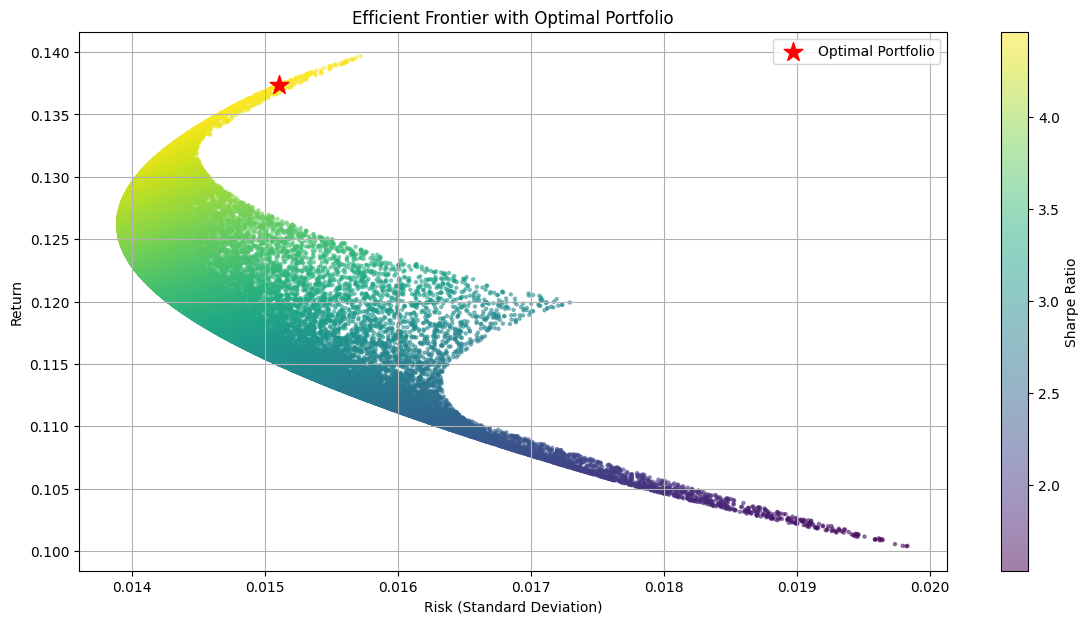

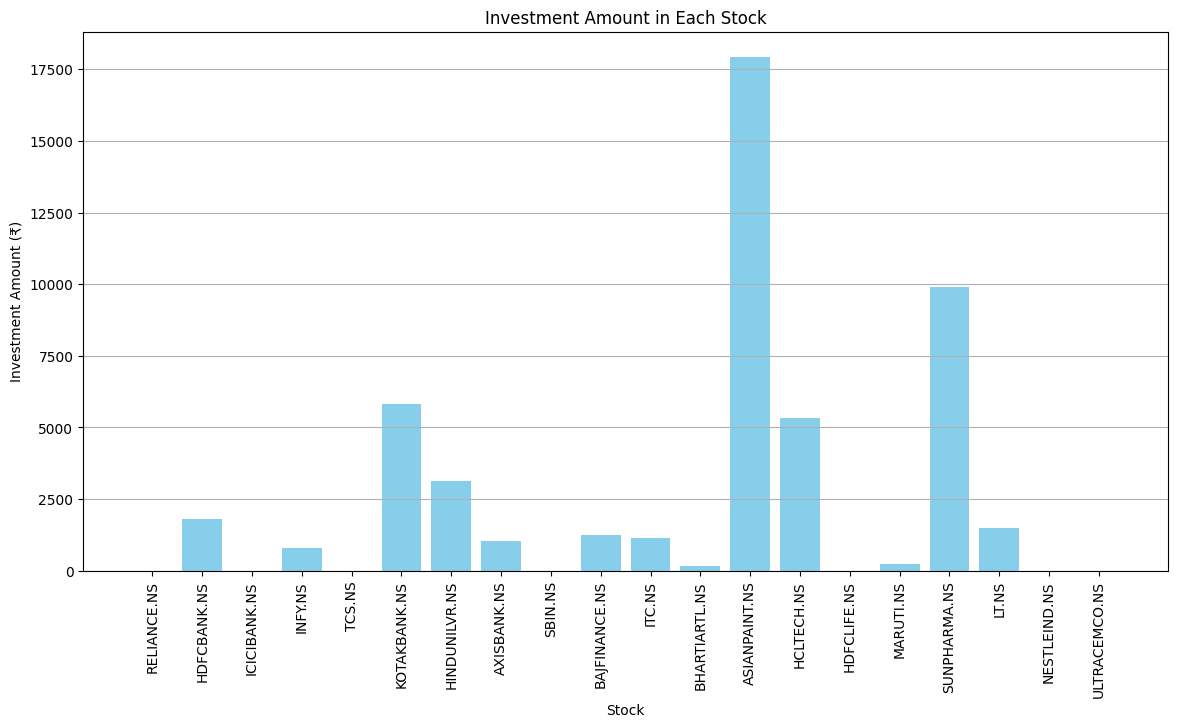

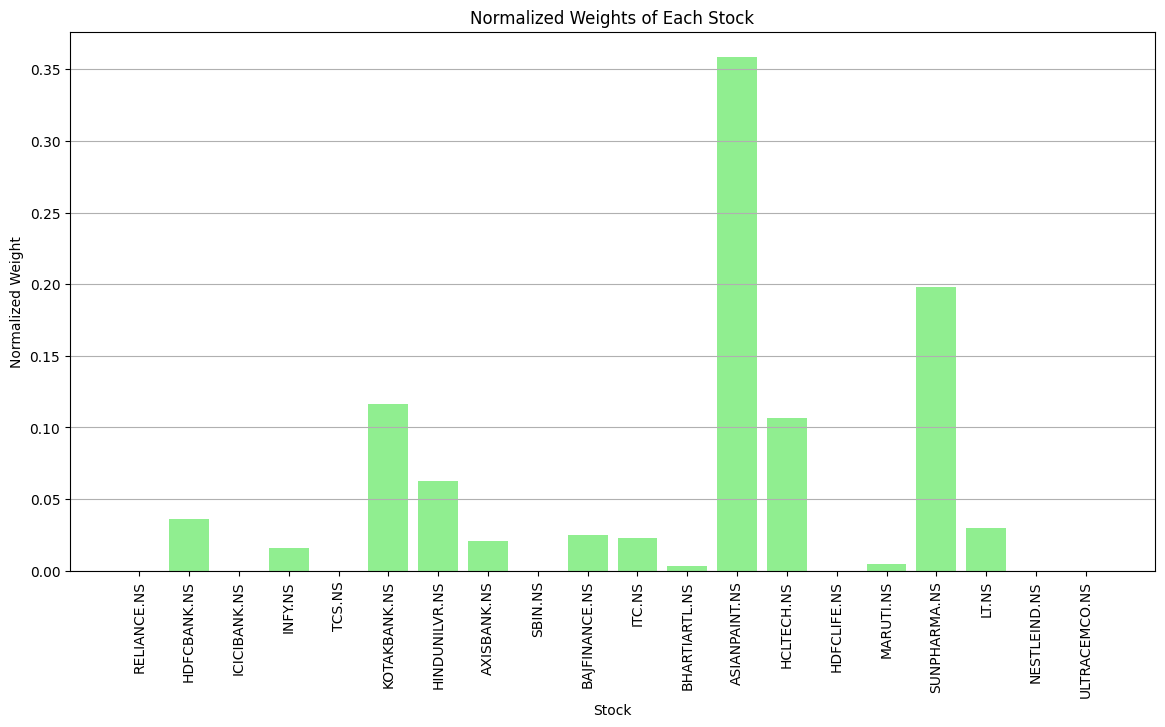

Optimal Portfolio with Highest Sharpe Ratio:
Return: 13.74%
Risk: 1.51%
Sharpe Ratio: 4.46
Weights in Each Asset:
Asset 1: 0.09%
Asset 2: 12.89%
Asset 3: 87.02%

Investment Amounts and Normalized Weights for Each Stock:
RELIANCE.NS: ₹0.00, Normalized Weight: 0.00%
HDFCBANK.NS: ₹1793.88, Normalized Weight: 3.59%
ICICIBANK.NS: ₹0.00, Normalized Weight: 0.00%
INFY.NS: ₹780.12, Normalized Weight: 1.56%
TCS.NS: ₹0.00, Normalized Weight: 0.00%
KOTAKBANK.NS: ₹5831.23, Normalized Weight: 11.66%
HINDUNILVR.NS: ₹3130.26, Normalized Weight: 6.26%
AXISBANK.NS: ₹1041.02, Normalized Weight: 2.08%
SBIN.NS: ₹0.00, Normalized Weight: 0.00%
BAJFINANCE.NS: ₹1236.83, Normalized Weight: 2.47%
ITC.NS: ₹1154.88, Normalized Weight: 2.31%
BHARTIARTL.NS: ₹154.04, Normalized Weight: 0.31%
ASIANPAINT.NS: ₹17913.65, Normalized Weight: 35.83%
HCLTECH.NS: ₹5344.81, Normalized Weight: 10.69%
HDFCLIFE.NS: ₹0.00, Normalized Weight: 0.00%
MARUTI.NS: ₹218.72, Normalized Weight: 0.44%
SUNPHARMA.NS: ₹9896.59, Normalized We

In [51]:
# Create a DataFrame for the investment data
investment_df = pd.DataFrame(data)

# Normalize the investment amounts to get portfolio weights
total_investment = investment_df['Investment Amount (₹)'].sum()
investment_df['Normalized Weight'] = investment_df['Investment Amount (₹)'] / total_investment

# Plot Efficient Frontier
plt.figure(figsize=(14, 7))

# Plot the Efficient Frontier
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', marker='o', s=5, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

# Plot the optimal portfolio
plt.scatter(optimal_risk, optimal_return, c='red', marker='*', s=200, label='Optimal Portfolio')

plt.title('Efficient Frontier with Optimal Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot Investment Amounts
plt.figure(figsize=(14, 7))
plt.bar(investment_df['Stock'], investment_df['Investment Amount (₹)'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Investment Amount in Each Stock')
plt.xlabel('Stock')
plt.ylabel('Investment Amount (₹)')
plt.grid(axis='y')
plt.show()

# Plot Normalized Weights
plt.figure(figsize=(14, 7))
plt.bar(investment_df['Stock'], investment_df['Normalized Weight'], color='lightgreen')
plt.xticks(rotation=90)
plt.title('Normalized Weights of Each Stock')
plt.xlabel('Stock')
plt.ylabel('Normalized Weight')
plt.grid(axis='y')
plt.show()

# Print the ideal portfolio details
print(f'Optimal Portfolio with Highest Sharpe Ratio:')
print(f'Return: {optimal_return:.2%}')
print(f'Risk: {optimal_risk:.2%}')
print(f'Sharpe Ratio: {optimal_sharpe:.2f}')
print(f'Weights in Each Asset:')

for i, weight in enumerate(optimal_weights):
    print(f'Asset {i+1}: {weight*100:.2f}%')

# Print the investment amounts and normalized weights
print('\nInvestment Amounts and Normalized Weights for Each Stock:')
for i, stock in enumerate(investment_df['Stock']):
    amount = investment_df['Investment Amount (₹)'].iloc[i]
    normalized_weight = investment_df['Normalized Weight'].iloc[i]
    print(f'{stock}: ₹{amount:.2f}, Normalized Weight: {normalized_weight*100:.2f}%')